##Configurações

In [1]:
!pip install scikeras==0.12.0
!pip install keras==2.15.0
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

## Modelo

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
dataset['populacao'].dtype

dtype('float64')

In [8]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [9]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [10]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

In [11]:
dataset['Porte'] = dataset['populacao'].apply(porte)

In [12]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0,1.070255,Pequeno Porte I
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0,1.104972,Pequeno Porte I
2,48,2010-01-01,AC,BRASILÉIA,22325.0,2.150056,Pequeno Porte II
3,2,2010-01-01,AC,BUJARI,8838.0,0.226296,Pequeno Porte I
4,4,2010-01-01,AC,CAPIXABA,9179.0,0.435777,Pequeno Porte I
...,...,...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0,1.212016,Pequeno Porte II
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0,0.621891,Pequeno Porte I
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0,0.466853,Pequeno Porte I
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0,1.069900,Pequeno Porte I


Filtro

In [13]:
dataset = dataset[dataset['Porte'] == 'Médio Porte']

In [14]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
5,249,2010-01-01,AC,CRUZEIRO DO SUL,81907.0,3.040033,Médio Porte
36,54,2010-01-01,AL,CAMPO ALEGRE,52041.0,1.037643,Médio Porte
45,55,2010-01-01,AL,CORURIPE,53387.0,1.030213,Médio Porte
88,64,2010-01-01,AL,PALMEIRA DOS ÍNDIOS,72064.0,0.888099,Médio Porte
94,138,2010-01-01,AL,PENEDO,61834.0,2.231782,Médio Porte
...,...,...,...,...,...,...,...
1024719,133,2024-04-01,SP,UBATUBA,80781.0,1.646427,Médio Porte
1024734,59,2024-04-01,SP,VINHEDO,65209.0,0.904783,Médio Porte
1024739,69,2024-04-01,SP,VOTUPORANGA,86820.0,0.794748,Médio Porte
1024799,75,2024-04-01,TO,GURUPI,78394.0,0.956706,Médio Porte


In [15]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-15-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [16]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [17]:
time_series

,taxa_internacao
Data completa,
2010-01-31,1.262302
2010-02-28,1.205797
2010-03-31,1.276683
2010-04-30,1.215884
2010-05-31,1.215052
...,...
2023-12-31,0.890539
2024-01-31,0.890174
2024-02-29,0.848012


In [18]:
time_series = time_series['2014-1-1':'2024-04-30']

In [19]:
time_series

,taxa_internacao
Data completa,
2014-01-31,1.056570
2014-02-28,1.028849
2014-03-31,1.026833
2014-04-30,1.008551
2014-05-31,1.058809
...,...
2023-12-31,0.890539
2024-01-31,0.890174
2024-02-29,0.848012


In [20]:
train_data= time_series.values

#Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

#Cria os Arrays No Formato Certo
x = []
y = []
for i in range(12, len(train_data)):
  x.append(train_data[i-12:i, 0])
  y.append(train_data[i,0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1],1))

#Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')


In [21]:
len(x)

112

In [22]:
x_train, y_train = x[:84], y[:84]
x_test, y_test = x[84:], y[84:]



In [23]:
len(x_test)

28

In [24]:
#Cria o Modelo De Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units = 800, return_sequences = True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units = 1, activation ='linear'))

regressor.compile(optimizer = 'adam', loss= 'mean_squared_error',
                  metrics = ['mean_squared_error'])


regressor.fit(x_train, y_train, epochs = 100, batch_size=16)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - loss: 0.2411 - mean_squared_error: 0.2411
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - loss: 0.0969 - mean_squared_error: 0.0969
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - loss: 0.0309 - mean_squared_error: 0.0309
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 0.0412 - mean_squared_error: 0.0412
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/s

In [25]:
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


In [26]:
train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])
forecasts = train_results['previsao']
#train_results

In [27]:
start_date = "2022-1-31"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='M')
train_results.set_index('data', inplace=True)

In [28]:
train_results

,previsao,valor_real
data,,
2022-01-31,0.738990,0.806979
2022-02-28,0.762427,0.738610
2022-03-31,0.748706,0.846133
2022-04-30,0.775310,0.867756
2022-05-31,0.815182,0.917178
2022-06-30,0.854287,0.911903
2022-07-31,0.866971,0.917154
2022-08-31,0.862211,0.939364
2022-09-30,0.864344,0.908139


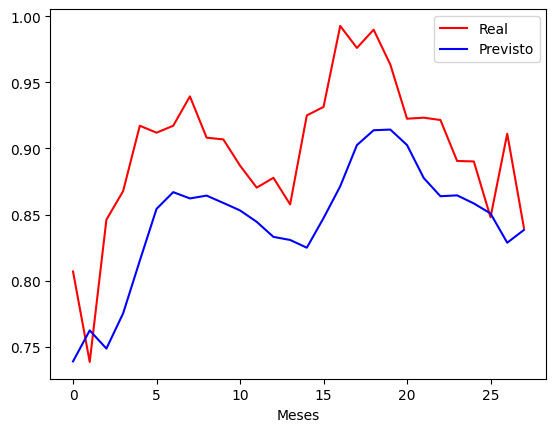

In [29]:
plt.plot(y_test, color='red', label = 'Real')
plt.plot(forecasts, color='blue', label = 'Previsto')
plt.xlabel('Meses')
plt.legend()
plt.show()

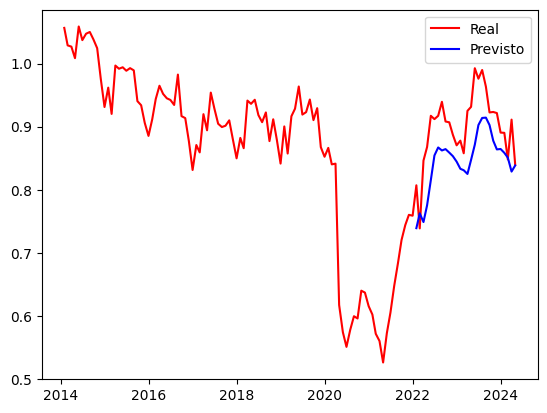

In [30]:
plt.plot(time_series, color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
plt.legend()
plt.show()

In [31]:
mse = mean_squared_error(y_test, forecasts)

In [32]:
mse

0.004065052

In [33]:
rmse = np.sqrt(mse)

In [34]:
rmse

0.06375776

In [35]:
tu = theil_u2(y_test, forecasts)

In [36]:
tu

1.4790559135407446

In [37]:
# Salva o DataFrame em um arquivo CSV
train_results.to_csv('predicao_previne_brasil_medio_porte_sem_dados_inputados(2014).csv', index=False)